In [1]:
import os
import glob

import numpy as np
import pandas as pd

from itertools import product

import seaborn as sns
import matplotlib.pyplot as plt

from utils.utility_functions import jaccard_index

In [2]:
# I/O

# read image patch dataframe
main = pd.read_csv(os.path.join(os.getcwd(), 'input/main.csv'))

# out dir
out = os.path.join(os.getcwd(), f'output/cluster_overlap')
if not os.path.exists(out):
    os.makedirs(out)

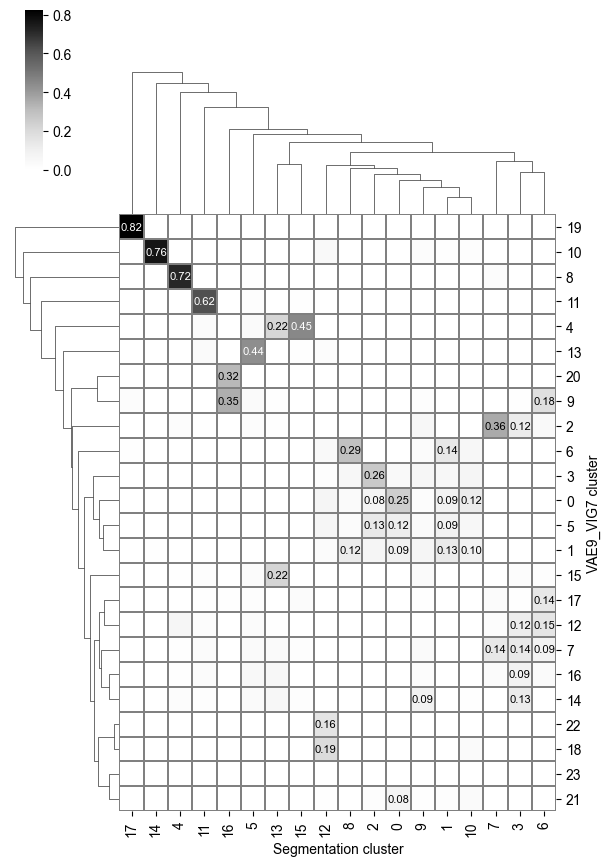

In [79]:
# group cell indices per cluster
seg_dict = {}
for name, group in main.groupby('Seg'):
    seg_dict[name] = group['CellID'].tolist()

vae_dict = {}
for name, group in main.groupby('VAE9_VIG7'):
    vae_dict[name] = group['CellID'].tolist()

# initialize Jaccard Index matrix with zeros
num_clusters_seg = len(seg_dict.keys())
num_clusters_vae = len(vae_dict.keys())
ji_matrix = [[0] * num_clusters_seg for _ in range(num_clusters_vae)] # VAE clusters will comprise matrix rows

# calculate Jaccard Index for each pair of clusters
for i, j in product(range(num_clusters_vae), range(num_clusters_seg)):
	ji_matrix[i][j] = jaccard_index(vae_dict[i], seg_dict[j])

plot_input = pd.DataFrame(ji_matrix)[::-1]

# plot
plt.rcParams['font.family'] = 'Arial'
g = sns.clustermap(
    plot_input, cmap='Greys', linecolor='gray', linewidth=0.1, 
    xticklabels=1, yticklabels=1, figsize=(6, 8), cbar_pos=(0.05, 0.85, 0.03, 0.2),
)
# Add custom annotations only for values above 0.1
for i in range(g.data2d.shape[0]):
    for j in range(g.data2d.shape[1]):
        value = g.data2d.iloc[i, j]
        if value >= 0.075:
            # choose text color based on the value
            text_color = 'white' if value >= 0.43 else 'black'
            g.ax_heatmap.text(j + 0.5, i + 0.5, f'{value:.2f}', color=text_color, 
                              ha='center', va='center', fontsize=8)

g.ax_heatmap.set_ylabel('VAE9_VIG7 cluster')
g.ax_heatmap.set_xlabel('Segmentation cluster')
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90)

plt.savefig(os.path.join(out, f'vae_seg_Jaccard_indices.pdf'), bbox_inches='tight')
plt.show()

In [54]:
# list VAE9 clusters whose max Jaccard index is >=0.6
indices = plot_input[plot_input.max(axis=1) >= 0.44].index
res = main[main['Seg'].isin(indices)]
print(f'Intensity-based clusters {", ".join(str(i) for i in indices[::-1])} account for {round(len(res)/len(main)*100)}% of total cells.')

Intensity-based clusters 4, 8, 10, 11, 13, 19 account for 29% of total cells.
